# Overture Maps

In [6]:
# Cell: Import Necessary Libraries
import os
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box
import duckdb



Data for Amsterdam, NL doesn't exist. Downloading.
Bounding Box - North: 52.4310638, South: 52.2781742, East: 5.0791622, West: 4.7287776


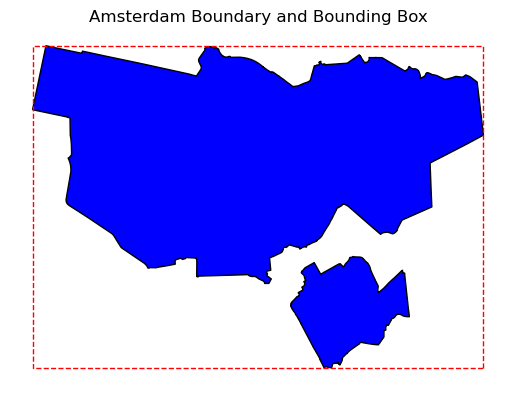

In [9]:
def prompt_user_for_city_and_country(default_city_name="Amsterdam", default_country_code="NL"):
    """Prompt user for city and country code, with defaults."""
    city_name = input(f"Enter the name of the city (default: {default_city_name}): ") or default_city_name
    country_code = input(f"Enter the country code (e.g., 'GB' for United Kingdom, default: {default_country_code}): ") or default_country_code
    return city_name, country_code

def get_and_save_city_boundary(city_name, country_code, file_path):
    """Get city boundary and save to GeoParquet if it doesn't exist."""
    if os.path.exists(file_path):
        print(f"Data for {city_name}, {country_code} already exists. Skipping download.")
    else:
        print(f"Data for {city_name}, {country_code} doesn't exist. Downloading.")
        city_boundary = ox.geocode_to_gdf(f"{city_name}, {country_code}")
        city_boundary.to_parquet(file_path, engine='pyarrow')
    return gpd.read_parquet(file_path)

def plot_city_boundary_and_bbox(city_boundary, title):
    """Plot city boundary and bounding box using GeoPandas."""
    bbox = city_boundary.total_bounds
    bbox_gdf = gpd.GeoDataFrame({'geometry': [box(*bbox)]}, crs=city_boundary.crs)
    ax = city_boundary.plot(color='blue', edgecolor='black')
    bbox_gdf.plot(ax=ax, color='none', edgecolor='red', linestyle='--')
    ax.set_title(title)
    ax.set_axis_off()

# Main execution
city_name, country_code = prompt_user_for_city_and_country()
geoparquet_file_path = f"../../data/0-raw/osmnx/boundaries/{city_name.lower().replace(' ', '_')}_boundary.parquet"

# Ensure directories exist
os.makedirs('../../data/0-raw/osmnx/boundaries', exist_ok=True)

city_boundary = get_and_save_city_boundary(city_name, country_code, geoparquet_file_path)
bbox_variable_name = f"bbox_{city_name.replace(' ', '_')}"
globals()[bbox_variable_name] = city_boundary.total_bounds
bbox = globals()[bbox_variable_name]
print(f"Bounding Box - North: {bbox[3]}, South: {bbox[1]}, East: {bbox[2]}, West: {bbox[0]}")
plot_city_boundary_and_bbox(city_boundary, f"{city_name} Boundary and Bounding Box")



In [10]:
import folium
import contextily as ctx
from shapely.geometry import box

# Create a small bounding box for the city of London, 200 by 200 meters
small_bbox_london = box(-0.1276 - 0.001, 51.5074 - 0.001, -0.1276 + 0.001, 51.5074 + 0.001)
small_bbox_gdf = gpd.GeoDataFrame({'geometry': [small_bbox_london]}, crs="EPSG:4326")

# Get the centroid of the bounding box for centering the map
centroid = small_bbox_london.centroid

# Create a Folium map centered on the centroid of the bounding box
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=18, tiles='OpenStreetMap')

# Add the small bounding box to the map
folium.GeoJson(small_bbox_gdf).add_to(m)

# Display the map
m
